In [59]:
import pandas as pd

import string
import nltk
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize #token
from nltk.stem import WordNetLemmatizer #lemma

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [74]:
#df = pd.read_csv('support_email_dataset.csv')
df = pd.read_csv('fake_news_data.csv')

In [75]:
df.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [76]:
# Define stopwords
stop_words = set(stopwords.words("english"))

In [77]:
# Define Lemmatizer
lemmatizer = WordNetLemmatizer()

In [78]:
def preprocess_text(text):
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # tokenize
    tokens = word_tokenize(text)
    # lemma + remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(tokens) # join back into string

In [80]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [81]:
df.head()


,title,text,date,fake_or_factual,clean_text
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problem analogy susan jesus muslim j...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york time r...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,woman make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,washington reuters u defense secretary jim mat...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,belfast reuters northern ireland political par...


In [91]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["fake_or_factual"], test_size = 0.2, random_state = 42)

In [92]:
# TF-IDF Vectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [93]:
# Logistic Regression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [94]:
# Evaluate
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Factual News       0.81      0.89      0.85        19
   Fake News       0.89      0.81      0.85        21

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



In [95]:
from sklearn.metrics import accuracy_score

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(acc)

0.85


In [96]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

[[17  2]
 [ 4 17]]


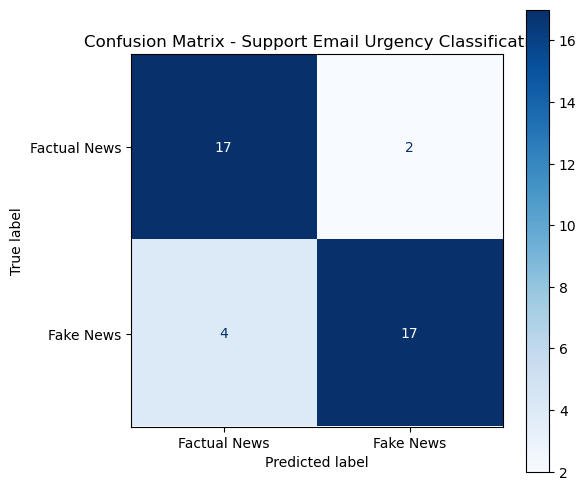

In [97]:
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Confusion Matrix - Support Email Urgency Classification")
plt.show()

In [100]:
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier().fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)
accuracy_score(y_pred_svm, y_test)

0.875

In [101]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.85      0.89      0.87        19
   Fake News       0.90      0.86      0.88        21

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.88        40



In [102]:
import xgboost as xgb

In [104]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit and transform the target column
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Check mapping
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")


Factual News -> 0
Fake News -> 1


In [106]:
# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',  # multi-class classification
    num_class= 2,  # number of classes
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Train
xgb_clf.fit(X_train_tfidf, y_train_enc)

# Predict
y_pred_xgb = xgb_clf.predict(X_test_tfidf)

# Accuracy
acc = accuracy_score(y_test_enc, y_pred_xgb)
print(f"XGBoost Accuracy: {acc:.2f}")

XGBoost Accuracy: 1.00


In [109]:
# Classification report
print(classification_report(y_test_enc, y_pred_xgb, target_names=le.classes_))

              precision    recall  f1-score   support

Factual News       1.00      1.00      1.00        19
   Fake News       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

